In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from catboost import CatBoostClassifier

from skopt import BayesSearchCV

from xgboost import XGBClassifier

import pickle

import animalhelper as ah

import matplotlib as mpl

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!ls data

aac_intakes.csv          df_dog.csv               master12218.csv
aac_intakes_outcomes.csv df_mod.csv               master_df.csv
aac_outcomes.csv         engineered.csv           master_df_1128.csv
all_categoricals.csv     group_shade.csv          master_df_1129.csv
concat_backup.csv        hour_ids.csv             model12218.csv
df_cat.csv               hr_name.csv


In [3]:
df = pd.read_csv('data/aac_outcomes.csv')

In [4]:
df = df.drop_duplicates(subset='animal_id')

In [98]:
mpl.rcParams['figure.dpi'] = 300

In [6]:
cat_boost = pickle.load(open('cat_boost_reduce.pkl', 'rb'))

In [7]:
features = pickle.load(open('features.pkl', 'rb'))
response = pickle.load(open('response.pkl', 'rb'))

In [8]:
X = features
y = response

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2325)

In [9]:
X_train.head()

,age,animal_type,fixed_status,group,intake_condition,intake_season,intake_type,hour_in,name_freq
37419,730,Dog,intact,Terrier,Normal,fall,Stray,9,36
17980,2190,Dog,intact,Herding,Normal,fall,Stray,10,33
52717,1460,Cat,fixed,short hair,Normal,fall,Owner Surrender,16,13
19058,730,Dog,intact,Toy,Normal,winter,Stray,17,0
34663,3650,Dog,fixed,Non-Sporting,Normal,summer,Owner Surrender,13,205


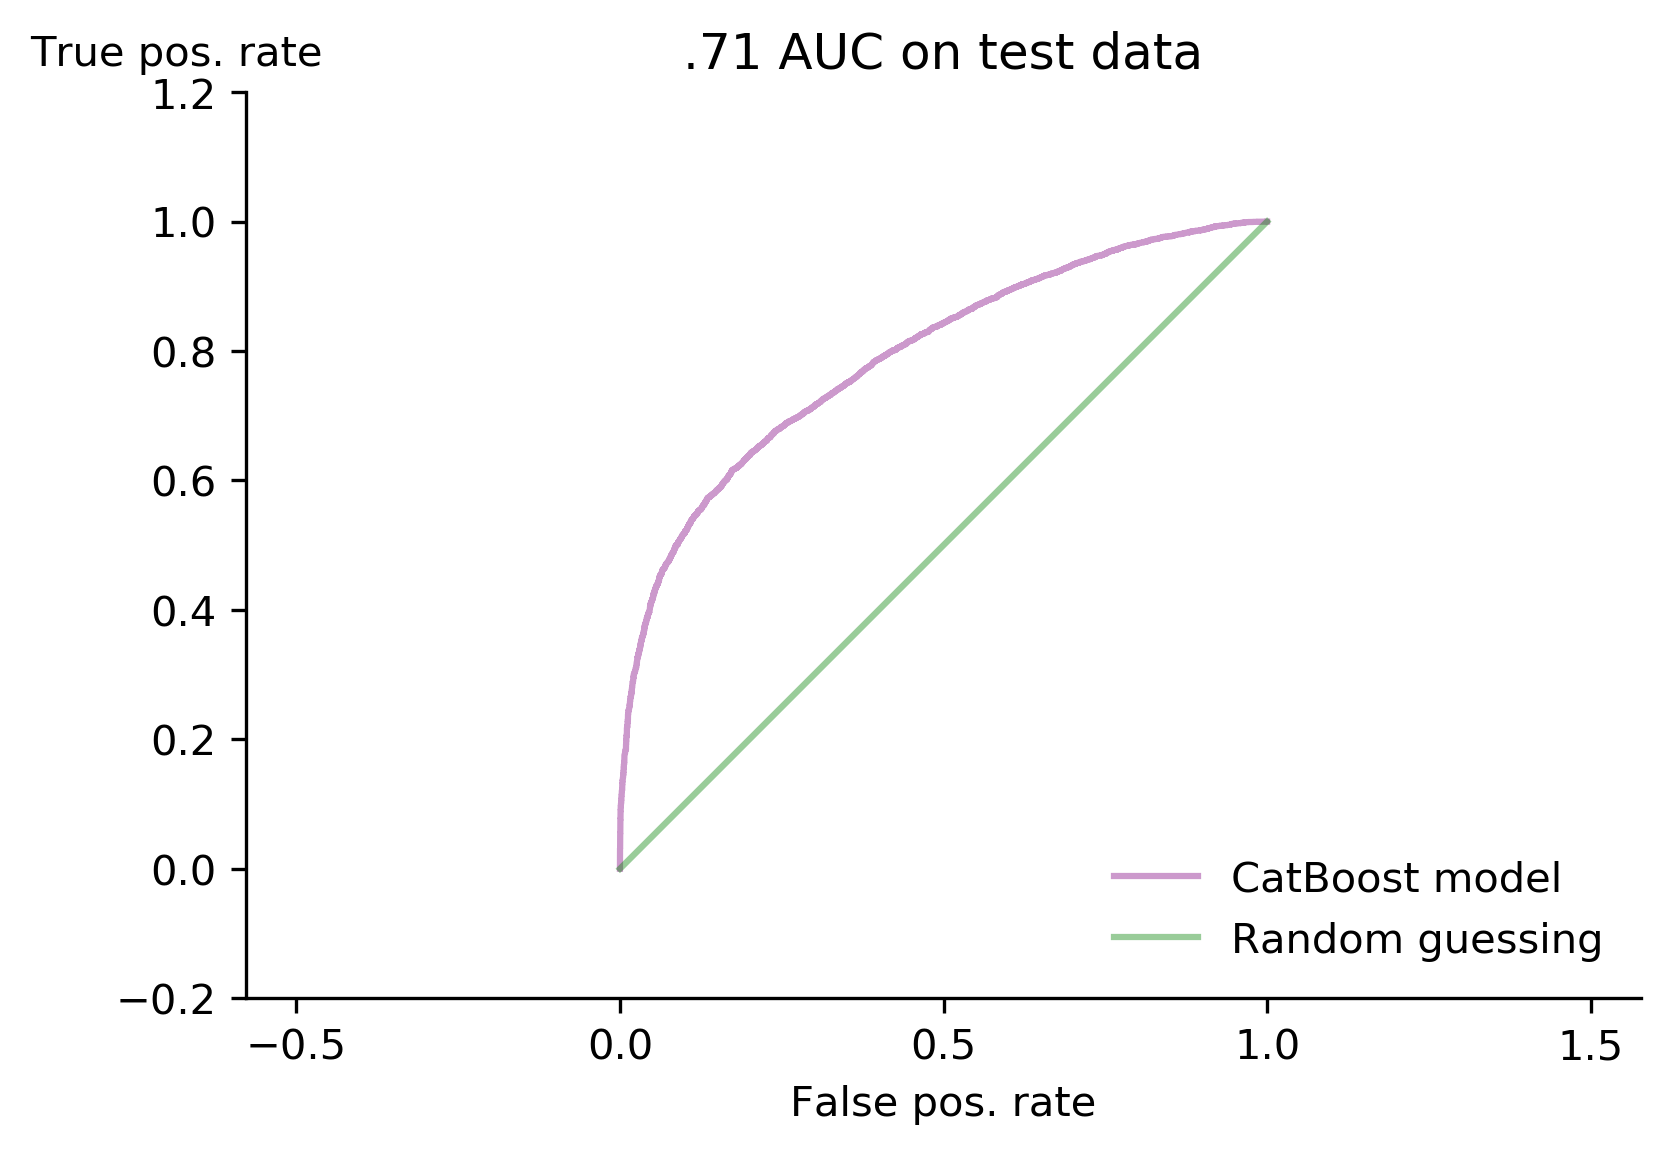

In [52]:
probs = cat_boost.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

l = np.linspace(0, 1, 100)

plt.plot(fpr, tpr, color='purple', alpha=0.4, label='CatBoost model')
plt.plot([0, 1], [0,1], color='green', alpha=0.4, label='Random guessing')

plt.xlabel('False pos. rate', size=10)
plt.ylabel('True pos. rate', rotation=0)
plt.title('.71 AUC on test data')
plt.tick_params(axis='both', which='major', labelsize=10)
#plt.tight_layout()

ax = plt.gca()
ax.yaxis.set_label_coords(-0.05,1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.axis([0, 1, 0, 1.05])

ax.axis('equal')

plt.legend(loc=4, frameon=False);

#plt.savefig('ROC_AUC.png');

<BarContainer object of 2 artists>

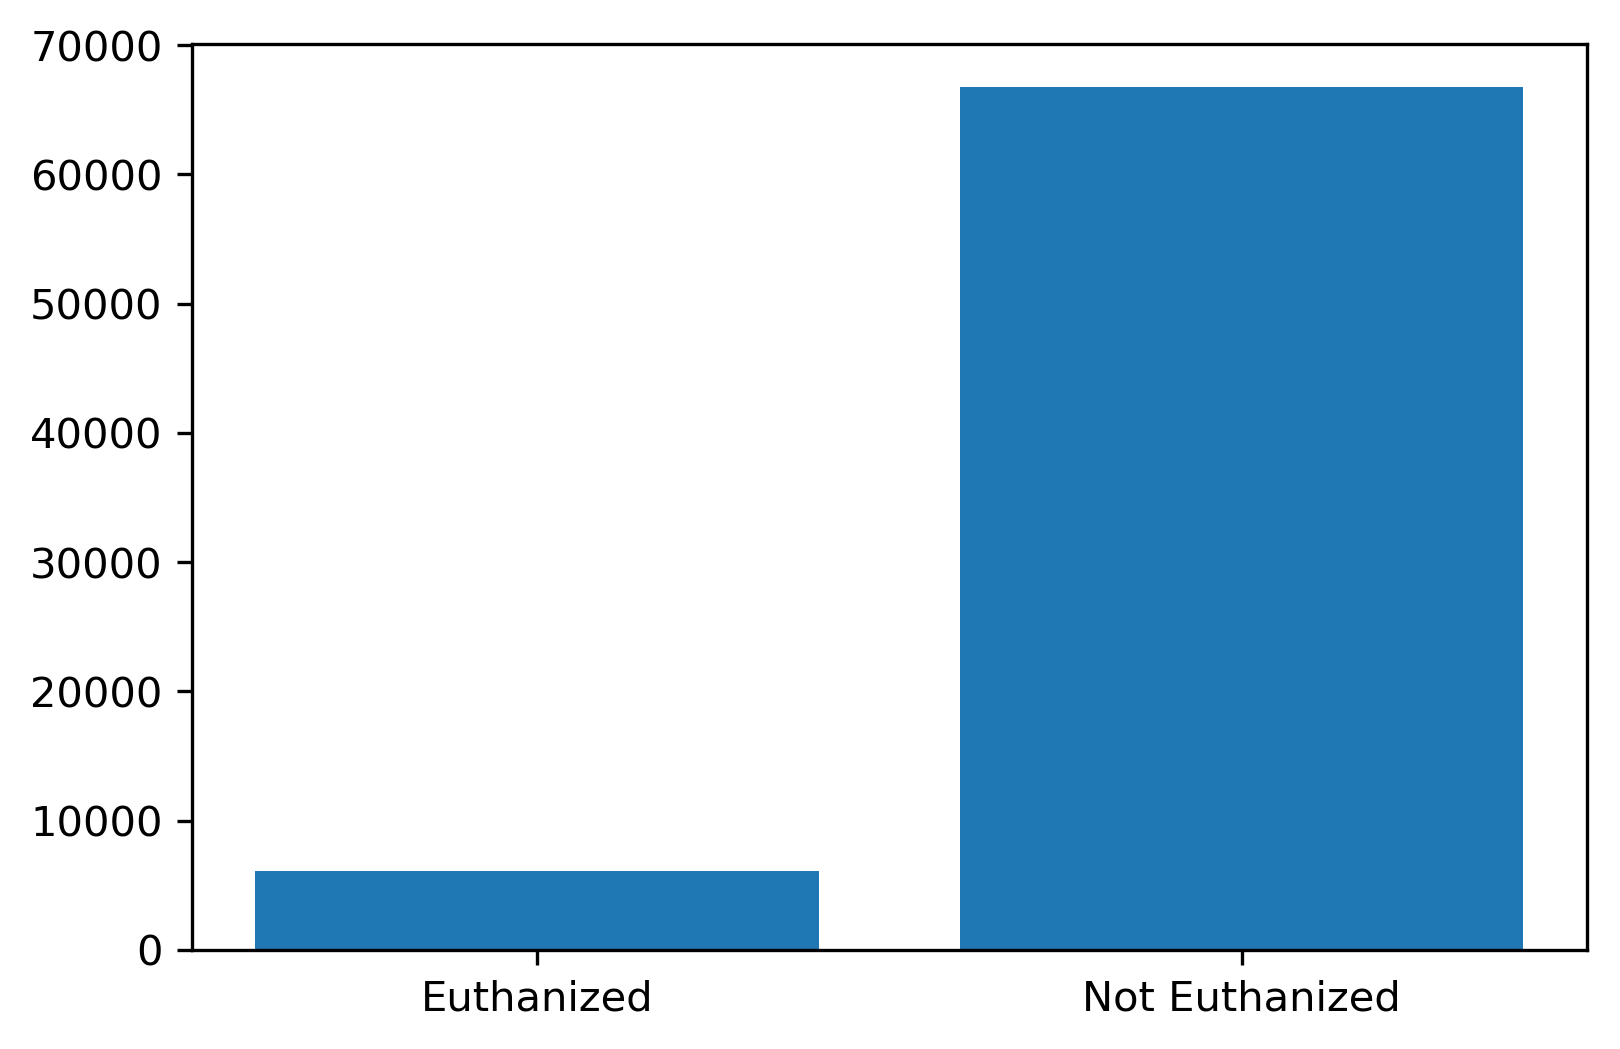

In [32]:
num_euthanasia = df['outcome_type'].value_counts()[3]
num_other = df['outcome_type'].value_counts().sum() - num_euthanasia

plt.bar(['Euthanized', 'Not Euthanized'], [num_euthanasia, num_other])

In [61]:
import itertools

In [56]:
hard_preds = []

for p in preds:
    if p >= .5:
        hard_preds.append(1)
    else:
        hard_preds.append(0)

In [58]:
cm = confusion_matrix(y_test, hard_preds)

In [118]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.figure(figsize=(8, 6))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, size=18)
    plt.yticks(tick_marks, classes, size=18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #print(i, j)
        #plt.text(j, i, format(cm[i, j], fmt),
                 #horizontalalignment="center",
                 #color="white" if cm[i, j] > thresh else "black")
                
        
    plt.text(0, 0, format(.80, fmt),
             horizontalalignment="center",
             color="white", size=16)
    plt.text(0, 1, format(.32, fmt),
             horizontalalignment="center",
             color="black", size=16)
    
    plt.text(1, 0, format(.20, fmt),
             horizontalalignment="center",
             color="black", size=16)
    plt.text(1, 1, format(.68, fmt),
             horizontalalignment="center",
             color="white", size=16)
    
    plt.ylabel('Ground truth', size=18)
    plt.xlabel('Prediction', size=18)
    plt.tight_layout()
    #plt.savefig('confusion_matrix.png')

In [68]:
print(classification_report(y_test, hard_preds))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71      7219
           1       0.77      0.68      0.72      8507

   micro avg       0.71      0.71      0.71     15726
   macro avg       0.72      0.72      0.71     15726
weighted avg       0.72      0.71      0.71     15726



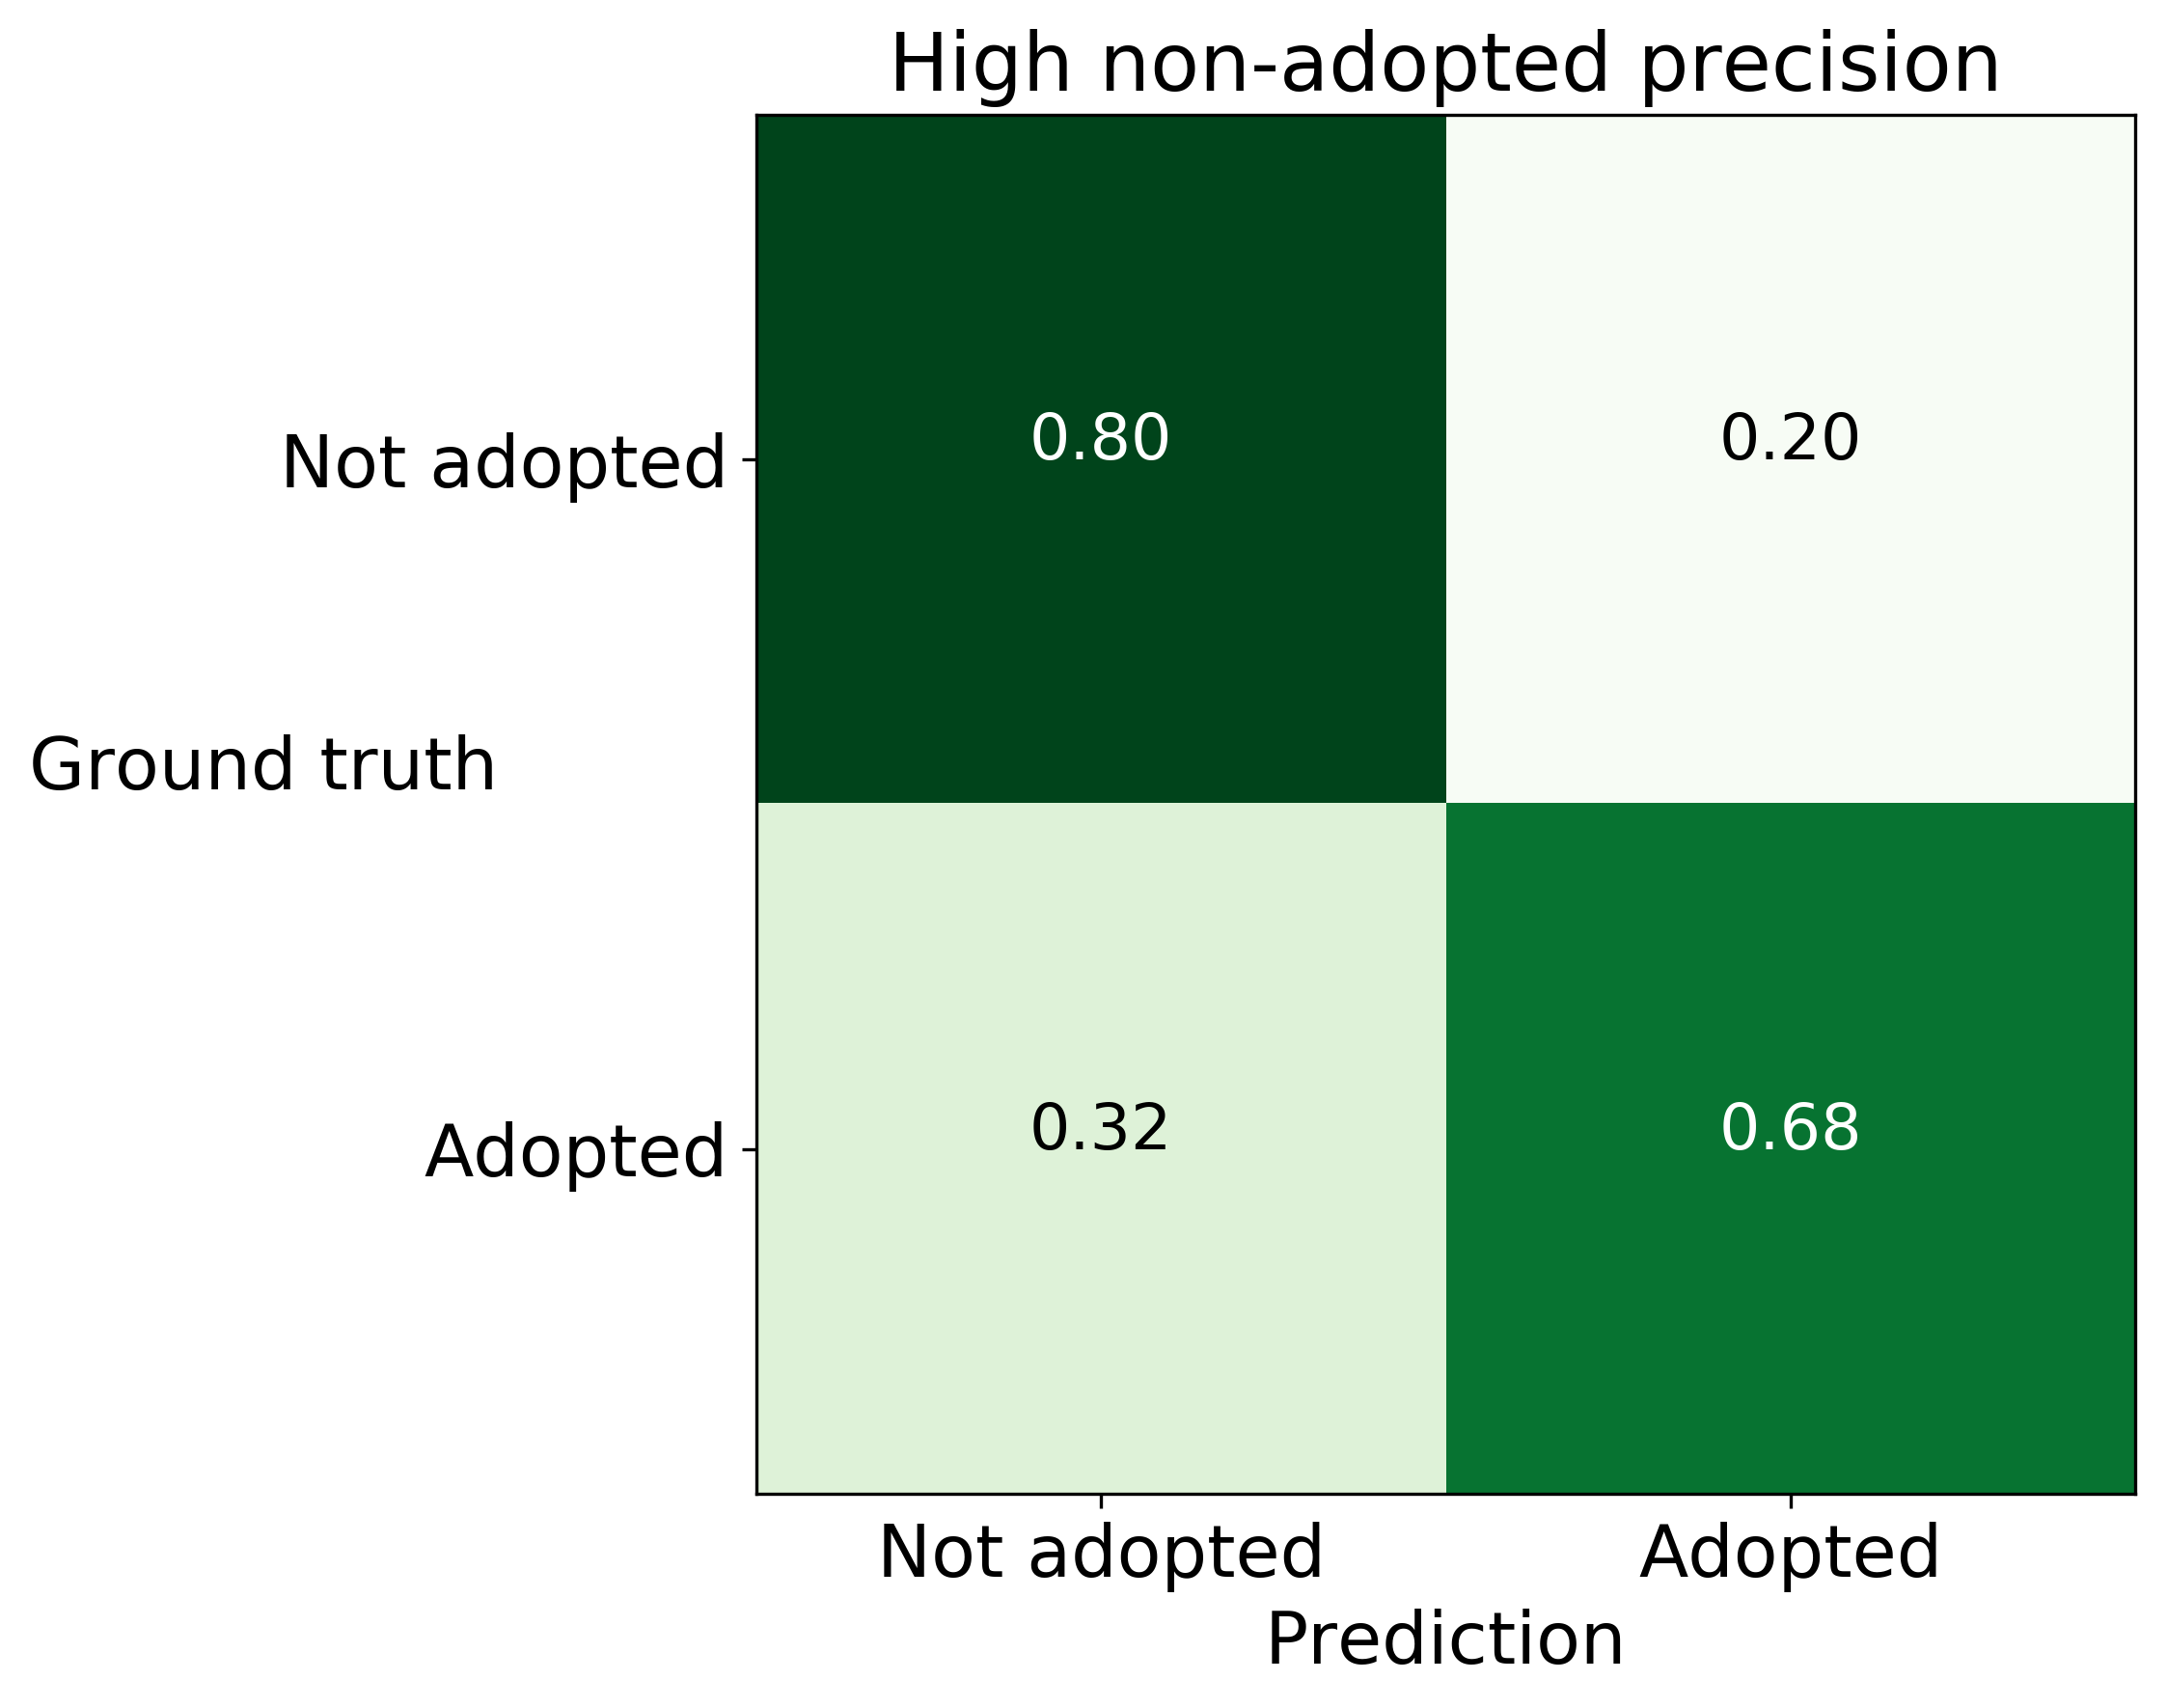

In [119]:
plot_confusion_matrix(cm, title= 'High non-adopted precision', normalize=True,
                      classes=['Not adopted', 'Adopted'], cmap=plt.cm.Greens)

## Get predictions

In [69]:
features = pickle.load(open('features.pkl', 'rb'))
response = pickle.load(open('response.pkl', 'rb'))

In [70]:
X_train, X_test, y_train, y_test = train_test_split(features, response, stratify=y, random_state=2325)

In [73]:
cat_adopt = pickle.load(open('good_at_adoption.pkl', 'rb'))